# Citibike Project - Normalizing the Datasets

Normalizing the bike share datsets from `03_normalizing_datasets.ipynb` to prepare for SQL database creation.

## Imports

In [1]:
import pandas as pd
import numpy as np

import polars as pl

import pyarrow as pa
import pyarrow.parquet as pq

import feather

from matplotlib import pyplot as plt

import os

## Files that we'll be working on: 
Two .CSVs, `group1` is ~10Gb and `group2` is ~20Gb

In [2]:
group1_location='/Users/sra/files/projects/citibike_project/combined/group1_combined/group1.csv'
group2_location='/Users/sra/files/projects/citibike_project/combined/group2_combined/group2.csv'

# Let's explore `group1` first:

In [3]:
q=(
    pl.scan_csv(group1_location,ignore_errors=True,try_parse_dates=True)
)

group1_pl=q.collect()

In [4]:
group1_pl.head()

ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
str,str,datetime[μs],datetime[μs],str,f64,str,f64,f64,f64,f64,f64,str
"""26A3DC47FE0EA3…","""docked_bike""",2021-05-13 12:48:08,2021-05-13 13:07:37,"""Broadway & W 2…",6173.08,"""E 2 St & Avenu…",5515.02,40.742868,-73.989186,40.722174,-73.983688,"""member"""
"""A99F2E1D627B08…","""docked_bike""",2021-05-16 08:30:13,2021-05-16 08:45:47,"""46 Ave & 5 St""",6286.02,"""34th Ave & Ver…",6873.01,40.74731,-73.95451,40.765354,-73.939863,"""member"""
"""43E79A45997B73…","""docked_bike""",2021-05-01 08:38:14,2021-05-01 08:54:27,"""46 Ave & 5 St""",6286.02,"""34th Ave & Ver…",6873.01,40.74731,-73.95451,40.765354,-73.939863,"""member"""
"""8B3CC649F4F588…","""docked_bike""",2021-05-09 08:12:31,2021-05-09 08:27:05,"""46 Ave & 5 St""",6286.02,"""34th Ave & Ver…",6873.01,40.74731,-73.95451,40.765354,-73.939863,"""member"""
"""7101C98F057486…","""docked_bike""",2021-05-27 07:52:27,2021-05-27 08:09:01,"""E 123 St & Lex…",7636.05,"""1 Ave & E 78 S…",7020.09,40.802926,-73.9379,40.771404,-73.953517,"""member"""


In [5]:
group1_pl.groupby('start_station_name').count()\
.sort('count',descending=True)\
.head()

start_station_name,count
str,u32
"""W 21 St & 6 Av…",247908
"""West St & Cham…",219580
"""1 Ave & E 68 S…",208483
"""6 Ave & W 33 S…",197135
"""Broadway & W 2…",194687


There are some junk stations in the dataset:

In [6]:
q=(
    group1_pl.lazy()
    .groupby('start_station_name')
    .agg(pl.count('start_station_name').alias('count'))
    .filter(
        (pl.col('count')>=10)
    )
    .sort('count',descending=True)
    # .limit(5)
)

group1_pl_count=q.collect()
print(group1_pl_count)

shape: (2_027, 2)
┌──────────────────────────┬────────┐
│ start_station_name       ┆ count  │
│ ---                      ┆ ---    │
│ str                      ┆ u32    │
╞══════════════════════════╪════════╡
│ W 21 St & 6 Ave          ┆ 247908 │
│ West St & Chambers St    ┆ 219580 │
│ 1 Ave & E 68 St          ┆ 208483 │
│ 6 Ave & W 33 St          ┆ 197135 │
│ …                        ┆ …      │
│ Prototype Lab            ┆ 15     │
│ Apache                   ┆ 15     │
│ Rogers Pl & E 165 St_old ┆ 11     │
│ 4455.10                  ┆ 11     │
└──────────────────────────┴────────┘


However, these junk stations are such a small part of the dataset that I think it's ok to include.  
When it comes time to query the database with `SQL`, we can work to remove these junk stations with more control.

In [7]:
q=(
    group1_pl.lazy()
    .groupby('start_station_id')
    .agg(pl.count('start_station_id').alias('count'))
    # .filter(
        # (pl.col('count')>=1)
    # )
    .sort('count',descending=True)
    # .limit(5)
)

group1_pl_count=q.collect()
print(group1_pl_count)

shape: (1_927, 2)
┌──────────────────┬────────┐
│ start_station_id ┆ count  │
│ ---              ┆ ---    │
│ f64              ┆ u32    │
╞══════════════════╪════════╡
│ 6140.05          ┆ 247908 │
│ 5329.03          ┆ 219580 │
│ 6822.09          ┆ 208483 │
│ 6364.07          ┆ 197135 │
│ …                ┆ …      │
│ 5548.01          ┆ 44     │
│ 3704.01          ┆ 33     │
│ 4014.01          ┆ 30     │
│ 8419.03          ┆ 2      │
└──────────────────┴────────┘


Practice making new columns of summary information using other columns:

In [8]:
q=(
    group1_pl.lazy()
    .groupby('rideable_type')
    .agg(pl.count('rideable_type').alias('rideable_type_count'))
    .sort('rideable_type_count',descending=True)
)

group1_pl_rideable_type=q.collect()

q=(
    group1_pl_rideable_type.lazy()
    .with_columns([pl.col("rideable_type_count").sum().alias('sum')])
)

group1_pl_rideable_type=q.collect()

print(group1_pl_rideable_type)

shape: (3, 3)
┌───────────────┬─────────────────────┬──────────┐
│ rideable_type ┆ rideable_type_count ┆ sum      │
│ ---           ┆ ---                 ┆ ---      │
│ str           ┆ u32                 ┆ u32      │
╞═══════════════╪═════════════════════╪══════════╡
│ classic_bike  ┆ 34010263            ┆ 55800085 │
│ electric_bike ┆ 13092408            ┆ 55800085 │
│ docked_bike   ┆ 8697414             ┆ 55800085 │
└───────────────┴─────────────────────┴──────────┘


There are about three times as many classic bike trips used than electric bikes used. The total amount of trips equals the total rows of the dataset.

In [9]:
q=(
    group1_pl.lazy()
    .groupby('member_casual')
    .agg(pl.count('member_casual').alias('member_casual_count'))
    .sort('member_casual_count',descending=True)
)

group1_pl_rider_type=q.collect()

print(group1_pl_rider_type)

shape: (2, 2)
┌───────────────┬─────────────────────┐
│ member_casual ┆ member_casual_count │
│ ---           ┆ ---                 │
│ str           ┆ u32                 │
╞═══════════════╪═════════════════════╡
│ member        ┆ 42560681            │
│ casual        ┆ 13239404            │
└───────────────┴─────────────────────┘


#### Determine the number and contents of secondary tables that are needed.

A `member_casual` table that has two rows, `member` and `casual`:

In [10]:
member_casual=group1_pl['member_casual'].value_counts().sort('counts',descending=True)
member_casual

member_casual,counts
str,u32
"""member""",42560681
"""casual""",13239404


In [11]:
sum(member_casual['counts'])

55800085

A `rideable_type` table that has three rows, `classic_bike`, `electric_bike`, and `docked_bike`:

In [12]:
group1_pl['rideable_type'].value_counts().sort('counts',descending=True)

rideable_type,counts
str,u32
"""classic_bike""",34010263
"""electric_bike""",13092408
"""docked_bike""",8697414


There are 1,926 stations in the database, plus a `null` entry:

In [13]:
group1_pl['start_station_id'].value_counts().sort('start_station_id',descending=True)

start_station_id,counts
f64,u32
8841.03,4503
8811.01,2113
8799.01,3221
8795.03,2011
8795.01,6404
8782.01,3084
8778.01,2968
8766.03,2209
8752.01,2996


## Normalize `group1`

### Ride table:

#### Normalize the `rideable_type` and `member_casual` categories:

In [14]:
group1_pl_intermediate=\
group1_pl.with_columns(
    pl.when(pl.col('member_casual') == 'member')
    .then(pl.lit(0))
    .otherwise(pl.lit(1))
    .alias('ridertype'))

group1_pl_intermediate.head()

# named intermediate because this is an intermediate step
# before finalizing this table of data

ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ridertype
str,str,datetime[μs],datetime[μs],str,f64,str,f64,f64,f64,f64,f64,str,i32
"""26A3DC47FE0EA3…","""docked_bike""",2021-05-13 12:48:08,2021-05-13 13:07:37,"""Broadway & W 2…",6173.08,"""E 2 St & Avenu…",5515.02,40.742868,-73.989186,40.722174,-73.983688,"""member""",0
"""A99F2E1D627B08…","""docked_bike""",2021-05-16 08:30:13,2021-05-16 08:45:47,"""46 Ave & 5 St""",6286.02,"""34th Ave & Ver…",6873.01,40.74731,-73.95451,40.765354,-73.939863,"""member""",0
"""43E79A45997B73…","""docked_bike""",2021-05-01 08:38:14,2021-05-01 08:54:27,"""46 Ave & 5 St""",6286.02,"""34th Ave & Ver…",6873.01,40.74731,-73.95451,40.765354,-73.939863,"""member""",0
"""8B3CC649F4F588…","""docked_bike""",2021-05-09 08:12:31,2021-05-09 08:27:05,"""46 Ave & 5 St""",6286.02,"""34th Ave & Ver…",6873.01,40.74731,-73.95451,40.765354,-73.939863,"""member""",0
"""7101C98F057486…","""docked_bike""",2021-05-27 07:52:27,2021-05-27 08:09:01,"""E 123 St & Lex…",7636.05,"""1 Ave & E 78 S…",7020.09,40.802926,-73.9379,40.771404,-73.953517,"""member""",0


In [15]:
# sanity check on the column that was just created
group1_pl_intermediate['ridertype'].value_counts().sort('counts',descending=True)

ridertype,counts
i32,u32
0,42560681
1,13239404


In [16]:
group1_pl_intermediate=\
group1_pl_intermediate.with_columns(
        pl.when(pl.col('rideable_type') == 'classic_bike')
        .then(pl.lit(0))
        .when(pl.col('rideable_type') == 'electric_bike')
        .then(pl.lit(1))
        .otherwise(pl.lit(2))
        .alias('biketype')
)

group1_pl_intermediate.head()

ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ridertype,biketype
str,str,datetime[μs],datetime[μs],str,f64,str,f64,f64,f64,f64,f64,str,i32,i32
"""26A3DC47FE0EA3…","""docked_bike""",2021-05-13 12:48:08,2021-05-13 13:07:37,"""Broadway & W 2…",6173.08,"""E 2 St & Avenu…",5515.02,40.742868,-73.989186,40.722174,-73.983688,"""member""",0,2
"""A99F2E1D627B08…","""docked_bike""",2021-05-16 08:30:13,2021-05-16 08:45:47,"""46 Ave & 5 St""",6286.02,"""34th Ave & Ver…",6873.01,40.74731,-73.95451,40.765354,-73.939863,"""member""",0,2
"""43E79A45997B73…","""docked_bike""",2021-05-01 08:38:14,2021-05-01 08:54:27,"""46 Ave & 5 St""",6286.02,"""34th Ave & Ver…",6873.01,40.74731,-73.95451,40.765354,-73.939863,"""member""",0,2
"""8B3CC649F4F588…","""docked_bike""",2021-05-09 08:12:31,2021-05-09 08:27:05,"""46 Ave & 5 St""",6286.02,"""34th Ave & Ver…",6873.01,40.74731,-73.95451,40.765354,-73.939863,"""member""",0,2
"""7101C98F057486…","""docked_bike""",2021-05-27 07:52:27,2021-05-27 08:09:01,"""E 123 St & Lex…",7636.05,"""1 Ave & E 78 S…",7020.09,40.802926,-73.9379,40.771404,-73.953517,"""member""",0,2


In [17]:
# sanity check on the column that was just created
group1_pl_intermediate['biketype'].value_counts().sort('counts',descending=True)

biketype,counts
i32,u32
0,34010263
1,13092408
2,8697414


So far so good. Now to finalize the `ride` table.

In [18]:
group1_pl_ridenorm=group1_pl_intermediate.select(pl.col('*').exclude(\
'rideable_type',
'member_casual',
'start_station_name',
'end_station_name',
'start_lat',
'end_lat',
'start_lng',
'end_lng'))

group1_pl_ridenorm.head()

ride_id,started_at,ended_at,start_station_id,end_station_id,ridertype,biketype
str,datetime[μs],datetime[μs],f64,f64,i32,i32
"""26A3DC47FE0EA3…",2021-05-13 12:48:08,2021-05-13 13:07:37,6173.08,5515.02,0,2
"""A99F2E1D627B08…",2021-05-16 08:30:13,2021-05-16 08:45:47,6286.02,6873.01,0,2
"""43E79A45997B73…",2021-05-01 08:38:14,2021-05-01 08:54:27,6286.02,6873.01,0,2
"""8B3CC649F4F588…",2021-05-09 08:12:31,2021-05-09 08:27:05,6286.02,6873.01,0,2
"""7101C98F057486…",2021-05-27 07:52:27,2021-05-27 08:09:01,7636.05,7020.09,0,2


In [19]:
# sanity check on the table that was just created
group1_pl_ridenorm['biketype'].value_counts().sort('counts',descending=True)

biketype,counts
i32,u32
0,34010263
1,13092408
2,8697414


### Station table:

In [20]:
group1_pl_stationnorm=group1_pl.\
select(pl.col('*')\
       .exclude('ride_id',
                'rideable_type',
                'started_at',
                'ended_at',
                'member_casual',
                'end_station_name',
                'end_station_id',
                'end_lat',
                'end_lng'
               ))

group1_pl_stationnorm.head()

start_station_name,start_station_id,start_lat,start_lng
str,f64,f64,f64
"""Broadway & W 2…",6173.08,40.742868,-73.989186
"""46 Ave & 5 St""",6286.02,40.74731,-73.95451
"""46 Ave & 5 St""",6286.02,40.74731,-73.95451
"""46 Ave & 5 St""",6286.02,40.74731,-73.95451
"""E 123 St & Lex…",7636.05,40.802926,-73.9379


I want to check to make sure that all the `station_id` are accounted for in the `start_station_id` column:

In [21]:
# check if all values in column_a are represented in column_b
all_values_included = (group1_pl['start_station_id'].is_in(group1_pl['end_station_id'])).all()

# print the result
print(all_values_included)

True


## Convert the `polars` tables into a form that will make it easy to convert to `MySQL`.

This is because the size of the tables warrants compression.

Save the following tables. 
* `group1_pl_ridenorm`
* `group1_pl_stationnorm`

They are currently in a `polars` data type:

In [22]:
type(group1_pl_ridenorm)

polars.dataframe.frame.DataFrame

We will convert the `polars` dataframe to a `parquet` dataframe before sending to `MySQL`:

In [23]:
path_to_group1_pl_ridenorm_parquet=\
'/Users/sra/files/projects/citibike_project/combined/group1_combined/group1_pl_ridenorm.parquet'

if not os.path.exists(path_to_group1_pl_ridenorm_parquet):
    group1_pl_ridenorm.write_parquet(path_to_group1_pl_ridenorm_parquet)

In [24]:
path_to_group1_pl_stationnorm_parquet=\
'/Users/sra/files/projects/citibike_project/combined/group1_combined/group1_pl_stationnorm.parquet'

if not os.path.exists(path_to_group1_pl_stationnorm_parquet):
    group1_pl_stationnorm.write_parquet(path_to_group1_pl_stationnorm_parquet)

Now we can proceed to create the `SQL` tables for **group1**!

# `group2`

In [25]:
from pathlib import Path

import pandas as pd
import numpy as np

import polars as pl

In [26]:
group2_full_location=Path('/Users/sra/files/projects/citibike_project/combined/group2_pl_full.parquet')

group2=pl.read_parquet(group2_full_location)

In [27]:
group2.shape

(225093064, 15)

In [28]:
group2.sample(n=10)

trip_duration,started_at,ended_at,start_station_id,start_station_name,start_lat,start_lng,end_station_id,end_station_name,end_lat,end_lng,bike_id,user_type,birth_year,gender
f64,datetime[μs],datetime[μs],f64,str,f64,f64,f64,str,f64,f64,f64,str,f64,f64
1336.0,null,null,536.0,"""1 Ave & E 30 S…",40.741444,-73.975361,361.0,"""Allen St & Hes…",40.716059,-73.991908,17960.0,"""Subscriber""",1986.0,2.0
118.0,null,null,3260.0,"""Mercer St & Bl…",40.727064,-73.996621,336.0,"""Sullivan St & …",40.730477,-73.999061,15906.0,"""Subscriber""",1970.0,1.0
2563.0,null,null,334.0,"""W 20 St & 7 Av…",40.742388,-73.997262,3927.0,"""Lenox Ave & W …",40.81296,-73.941878,43503.0,"""Subscriber""",1975.0,1.0
622.0,null,2016-01-07 06:54:14,3230.0,"""Penn Station V…",40.751284,-73.996924,3233.0,"""E 48 St & 5 Av…",40.757246,-73.978059,16918.0,"""Subscriber""",1964.0,1.0
393.0,2014-05-29 11:22:03,2014-05-29 11:28:36,469.0,"""Broadway & W 5…",40.763441,-73.982681,488.0,"""W 39 St & 9 Av…",40.756458,-73.993722,15717.0,"""Subscriber""",1968.0,1.0
1144.0,2017-09-08 08:17:31,2017-09-08 08:36:36,284.0,"""Greenwich Ave …",40.739017,-74.002638,304.0,"""Broadway & Bat…",40.704633,-74.013617,25934.0,"""Subscriber""",1965.0,1.0
628.0,2017-10-28 15:42:37,2017-10-28 15:53:06,173.0,"""Broadway & W 4…",40.760683,-73.984527,484.0,"""W 44 St & 5 Av…",40.755003,-73.980144,31395.0,"""Customer""",null,0.0
245.0,null,null,259.0,"""South St & Whi…",40.701221,-74.012342,2008.0,"""Little West St…",40.705693,-74.016777,30240.0,"""Subscriber""",1946.0,1.0
2030.0,null,null,3304.0,"""6 Ave & 9 St""",40.668127,-73.983776,3467.0,"""W Broadway & S…",40.724947,-74.001659,35204.0,"""Subscriber""",1977.0,1.0


In [29]:
group2.groupby('start_station_name').count()\
.sort('count',descending=True).head(10)

start_station_name,count
str,u32
null,11663330
"""Pershing Squar…",1543232
"""E 17 St & Broa…",1438584
"""W 21 St & 6 Av…",1383136
"""West St & Cham…",1327624
"""8 Ave & W 31 S…",1274724
"""Broadway & E 2…",1271352
"""Broadway & E 1…",1207014
"""Lafayette St &…",1176504


`filter` to remove any `None` values in the 'started_at' or 'ended_at' columns

In [30]:
group2_no_datetime_nulls=group2.filter(pl.col('started_at') != None)
group2_no_datetime_nulls=group2_no_datetime_nulls.filter(pl.col('ended_at') != None)
group2_no_datetime_nulls.sample(10)

trip_duration,started_at,ended_at,start_station_id,start_station_name,start_lat,start_lng,end_station_id,end_station_name,end_lat,end_lng,bike_id,user_type,birth_year,gender
f64,datetime[μs],datetime[μs],f64,str,f64,f64,f64,str,f64,f64,f64,str,f64,f64
801.0,2017-07-30 19:23:43,2017-07-30 19:37:04,462.0,"""W 22 St & 10 A…",40.74692,-74.004519,505.0,"""6 Ave & W 33 S…",40.749013,-73.988484,20656.0,"""Customer""",null,0.0
938.0,2017-09-05 18:32:42,2017-09-05 18:48:21,3243.0,"""E 58 St & 1 Av…",40.758924,-73.962262,3125.0,"""45 Rd & 11 St""",40.747086,-73.949772,28116.0,"""Subscriber""",1983.0,2.0
470.0,2014-02-01 15:03:57,2014-02-01 15:11:47,2003.0,"""1 Ave & E 18 S…",40.734161,-73.980243,317.0,"""E 6 St & Avenu…",40.724537,-73.981854,15712.0,"""Subscriber""",1969.0,1.0
678.0,2014-08-17 10:59:36,2014-08-17 11:10:54,466.0,"""W 25 St & 6 Av…",40.743954,-73.991449,352.0,"""W 56 St & 6 Av…",40.763406,-73.977225,18491.0,"""Subscriber""",1981.0,1.0
484.0,2013-09-30 07:58:02,2013-09-30 08:06:06,355.0,"""Bayard St & Ba…",40.716021,-73.999744,281.0,"""Grand Army Pla…",40.764397,-73.973715,17360.0,"""Subscriber""",1963.0,1.0
598.0,2015-02-11 10:28:17,2015-02-11 10:38:15,442.0,"""W 27 St & 7 Av…",40.746647,-73.993915,161.0,"""LaGuardia Pl &…",40.72917,-73.998102,23767.0,"""Subscriber""",1979.0,2.0
287.0,2013-09-27 20:29:14,2013-09-27 20:34:01,494.0,"""W 26 St & 8 Av…",40.747348,-73.997236,463.0,"""9 Ave & W 16 S…",40.742065,-74.004432,17673.0,"""Subscriber""",1986.0,1.0
1451.0,2015-04-07 09:12:44,2015-04-07 09:36:55,387.0,"""Centre St & Ch…",40.712733,-74.004607,390.0,"""Duffield St & …",40.692216,-73.984284,19755.0,"""Subscriber""",1981.0,1.0
407.0,2017-09-14 20:22:11,2017-09-14 20:28:58,285.0,"""Broadway & E 1…",40.734546,-73.990741,432.0,"""E 7 St & Avenu…",40.726218,-73.983799,30928.0,"""Subscriber""",1972.0,1.0


In [31]:
group2_no_datetime_nulls.shape

(39306552, 15)

In [32]:
group2_no_datetime_nulls.null_count()

trip_duration,started_at,ended_at,start_station_id,start_station_name,start_lat,start_lng,end_station_id,end_station_name,end_lat,end_lng,bike_id,user_type,birth_year,gender
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,4675892,0


In [33]:
print(f'The percentage of nulls in birth year \n\
to total count of rows in the dataset is: \
{round((group2_no_datetime_nulls["birth_year"].null_count() / group2_no_datetime_nulls.shape[0])* 100, 2)}%')

The percentage of nulls in birth year 
to total count of rows in the dataset is: 11.9%


In [34]:
group2_no_datetime_nulls.groupby('birth_year').count()\
.filter(pl.col('birth_year') >= 1923)\
.sort('birth_year',descending=True).head(10)

birth_year,count
f64,u32
2001.0,10310
2000.0,31750
1999.0,61742
1998.0,107064
1997.0,142054
1996.0,198332
1995.0,274084
1994.0,436230
1993.0,672594


`filter` to remove any `None` values in the 'birth_year' column:

In [35]:
group2_no_nulls=group2_no_datetime_nulls.filter(pl.col('birth_year') != None)
group2_no_nulls.shape

(34630660, 15)

In [36]:
print(f"The ratio of non-subscribers to subscribers is: \n\
{round(sum(group2_no_nulls['user_type']!='Subscriber') / sum(group2_no_nulls['user_type']=='Subscriber'),2) * 100}%")

The ratio of non-subscribers to subscribers is: 
1.0%


What I want to know is if there is anything explaining the vast amount of 'nulls' in the 'started_at' and 'ended_at' columns for `group2`

First, save the no_nulls dataframe to parquet as a way to save our progress:

In [37]:
group2_no_nulls_location=Path('/Users/sra/files/projects/citibike_project/combined/group2_no_nulls.parquet')

group2_no_nulls.write_parquet(group2_no_nulls_location)

In [1]:
import seaborn as sns
import pandas as pd
import polars as pl
import numpy as np

group2_no_nulls_location='/Users/sra/files/projects/citibike_project/combined/group2_no_nulls.parquet'

Open the no_nulls parquet file and save it as a pandas dataframe so that seaborn can manipulate it:

In [2]:
group2_no_nulls_pd = pd.read_parquet(path=group2_no_nulls_location)

In [3]:
group2_no_nulls_pd.sample(5)

,trip_duration,started_at,ended_at,start_station_id,start_station_name,start_lat,start_lng,end_station_id,end_station_name,end_lat,end_lng,bike_id,user_type,birth_year,gender
4993160,331.0,2014-08-23 17:52:58,2014-08-23 17:58:29,406.0,Hicks St & Montague St,40.695128,-73.995951,217.0,Old Fulton St,40.702772,-73.993836,20845.0,Subscriber,1934.0,1.0
3577649,760.0,2016-01-06 19:26:44,2016-01-06 19:39:25,3244.0,University Pl & E 8 St,40.731437,-73.994903,341.0,Stanton St & Mangin St,40.717821,-73.976289,20241.0,Subscriber,1991.0,1.0
33066427,1471.0,2017-10-03 14:45:26,2017-10-03 15:09:57,3167.0,Amsterdam Ave & W 73 St,40.779668,-73.980930,450.0,W 49 St & 8 Ave,40.762272,-73.987882,28809.0,Subscriber,1983.0,2.0
25484604,438.0,2013-11-09 14:51:11,2013-11-09 14:58:29,375.0,Mercer St & Bleecker St,40.726795,-73.996951,301.0,E 2 St & Avenue B,40.722174,-73.983688,17827.0,Subscriber,1993.0,1.0
22193034,444.0,2014-08-19 18:01:42,2014-08-19 18:09:06,505.0,6 Ave & W 33 St,40.749013,-73.988484,509.0,9 Ave & W 22 St,40.745497,-74.001971,19395.0,Subscriber,1976.0,1.0


Now make a `sns.pairplot` to explore:

In [9]:
group2_no_nulls_pd_sample100k=group2_no_nulls_pd.sample(n=100000)

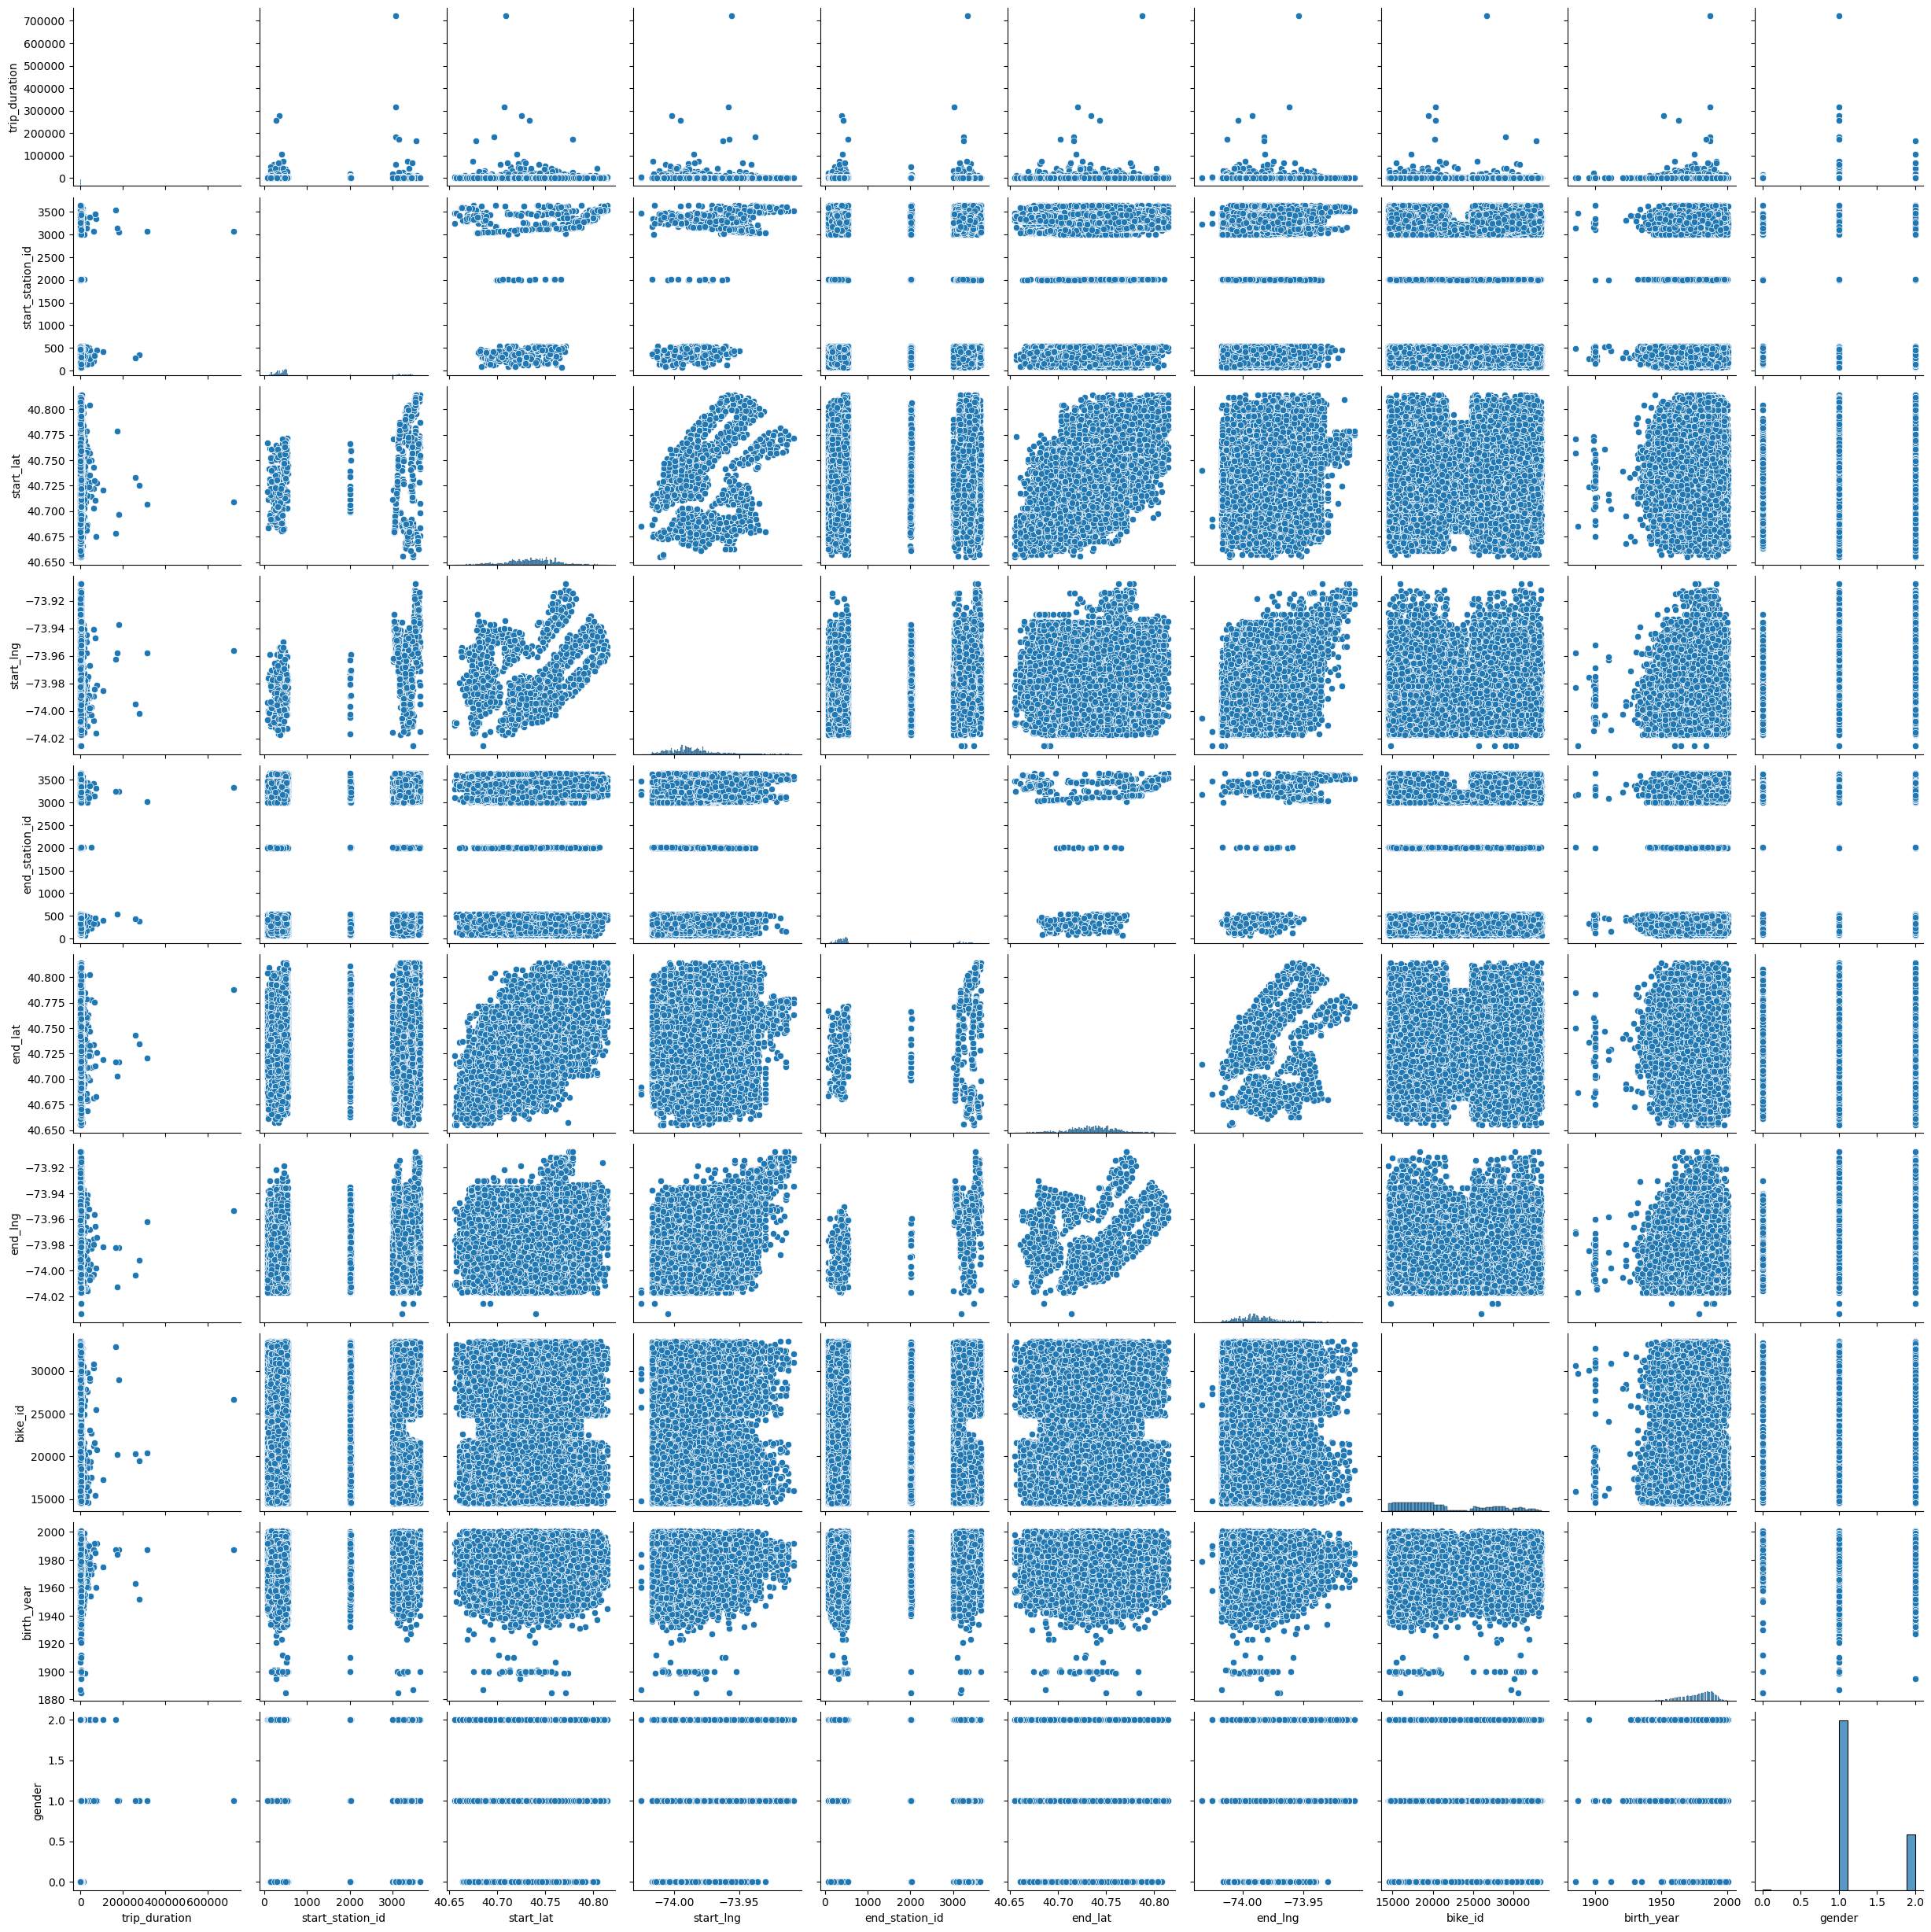

In [10]:
fig=sns.pairplot(group2_no_nulls_pd_sample100k)

In [11]:
fig.savefig('../figs/pairplot.png')